In [185]:
import torch
from torch import nn
from helper import supress_tracer_warnings, assert_shape, is_list_of_str, normalise_2nd_moment

from typing import Optional, Any, List
import numpy as np
import matplotlib.pyplot as plt

from shared import FullyConnectedLayers

In [ ]:
import sys
import os

cur_path = ''.join(os.getcwd().split('/')[:-1])
sys.path.insert(0, f'{cur_path}/torch_utils/ops')
sys.path.insert(0, f'{cur_path}/torch_utils')

In [3]:
import conv2d_resample

In [4]:
def modulated_conv2d(x: torch.Tensor, weight: torch.Tensor, styles: torch.Tensor, noise: Optional[torch.Tensor] = None,
                     up: int = 1, down: int = 1, padding: int = 0, resample_filter: Optional[List[int]] = None, 
                     demodulate: bool = True, flip_weight: bool = True, fused_mod_cov: bool = True) -> torch.Tensor:
    
    # x:      [B, inC, H, W]
    # weight: [outC, inC, kh, kw]
    # styles: [B, inC]

    batch_size = x.shape[0]
    out_channels, in_channels, kw, kh = weight.shape
    assert_shape(weight, [out_channels, in_channels, kw, kh])
    assert_shape(x, [batch_size, in_channels, None, None])    # x's & weight's batch_size and In channels must remain same
    assert_shape(styles, [batch_size, in_channels])

    if x.dtype == torch.float16 and demodulate:
        a = 1 / np.sqrt(in_channels * kh * kw)
        b = weight.norm(p = float("inf"), dim = [1,2,3], keepdim=True)          # max of inC, kh, kw
        weight = weight * (a / b)

        styles = styles / styles.norm(p = float('inf'), dim = [1], keep_dim = True) # max of inC
    
    w = None
    dcoef = None
    if demodulate or fused_mod_cov:
        w = weight.unsqueeze(0)                                    # w:      [1, outC, inC, kh, kw]
        w = w * styles.reshape(batch_size, 1, -1, 1, 1)            # styles: [B,  1,   inC, 1,  1]
                                                                   # w:      [B, outC, inC, kh, kw]
    if demodulate:
        dcoef = (w.square().sum(dim=[2,3,4]) + 1e-8).rsqrt()       # dcoef:  [B, outC]
    
    if demodulate and fused_mod_cov:
        w = w * dcoef.reshape(batch_size, -1, 1, 1, 1)             # w:      [B, outC, inC, kh, kw]
    
    if not fused_mod_cov:
        x = x * styles.reshape(batch_size, -1, 1, 1)                 # style: [B, inC x kh x kw, C, 1, 1]
        x = conv2d_resample.conv2d_resample(x=x, w=weight.to(x.dtype), f=resample_filter, up=up, down=down, padding=padding, flip_weight=flip_weight)
        x = x.reshape(batch_size, -1, *x.shape[2:])
        if noise is not None:
            x = x.add_(noise)
    return x

In [5]:
modulated_conv2d(
    x = torch.rand(5, 3, 10, 10),
    weight = torch.rand(6, 3, 5, 5),
    styles =  torch.rand(5, 3),
    up = 3,
    fused_mod_cov = False
).shape

torch.Size([5, 6, 26, 26])

In [6]:
class GroupNorm_float32(nn.GroupNorm):
    def forward(self, x: torch.Tensor):
        return super().forward(x.float()).type(x.dtype) # Converts x to float32 -> applies Group norm -> converts back to original type

x = torch.randn(8, 32, 64, 64).half()  # float16 tensor

gn = GroupNorm_float32(num_groups=8, num_channels=32)
y = gn(x)
y.dtype

torch.float16

In [7]:
class StyleSplit(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, **kwargs):
        super().__init__()

        self.fcl = FullyConnectedLayers(in_features=in_channels, out_features = 3*out_channels, **kwargs)
    
    def forward(self, x: torch.Tensor):
        x = self.fcl(x)
        m1, m2, m3 = x.chunk(chunks=3, dim=1)
        return m1 * m2 + m3

In [8]:
ss = StyleSplit(in_channels=2, out_channels=5)

x = torch.rand([10, 2])
ss(x).shape

torch.Size([10, 5])

In [182]:
class SynthesisInput(nn.Module):
    """
    Latent w → SynthesisInput → Feature map [B, 64, 64, 64]

    sin(2pi (f . x + phi))
    
    Where:
	•	f = 2D frequency vector (learned)
	•	x = pixel location
	•	phi = phase offset (learned)
	•	All of this is modulated by latent vector w through an affine transformation
    """

    def __init__(self, w_dim: int, channels: int, size: int, sampling_rate: int, bandwidth: int):
        super().__init__()

        self.w_dim = w_dim
        self.channels = channels
        self.size = np.broadcast_to(size, [2])
        self.sampling_rate = sampling_rate
        self.bandwidth = bandwidth

        # Draw random frequencies from uniform 2D disc.
        freqs = torch.rand([self.channels, 2])                      # Gausian Cloud in 2D space
        radii = freqs.square().sum(dim = 1, keepdim=True).sqrt()    # r = sqrt(x^2 + y^2)
        freqs = freqs / (radii * radii.square().exp().pow(0.25))    # freqs = freqs / r x exp(0.25 x r^2)}
        freqs *= bandwidth
        phases = torch.rand([self.channels]) - 0.5                  # values are in range [-0.5, 0.5]

        self.weights = nn.Parameter(torch.randn([self.channels, self.channels]))
        self.affine = FullyConnectedLayers(in_features=w_dim, 
                                           out_features=4,
                                           weight_init = 0,
                                           bias_init=[1,0,0,0])
        
        self.register_buffer("transforms", torch.eye(3,3))
        self.register_buffer("freqs", freqs)
        self.register_buffer("phases", phases)

    def forward(self, w: torch.Tensor): 
        # w = [B, w_dim]
        transforms = self.transforms.unsqueeze(0)                                   # [batch, row, col]
        freqs = self.freqs.unsqueeze(0)                                             # [batch, channels, 2] since 2D space, xy
        phases = self.phases.unsqueeze(0)                                           # [batch, channels]

        t = self.affine(w)                                                          # t: [batch, 4]
        t = t / t[:, :2].norm(dim = 1, keepdim = True)                              # t: [batch, 4] / [5, 1] -> [batch, 4]

        m_r = torch.eye(3, device=w.device).unsqueeze(0).repeat([w.shape[0], 1, 1]) # m_r = [batch, 3, 3] Identity matrix     ROTATION
        m_r[:, 0, 0] = t[:, 0]  # r'_c
        m_r[:, 0, 1] = -t[:, 1] # r'_s
        m_r[:, 1, 0] = t[:, 1]  # r'_s
        m_r[:, 1, 1] = t[:, 0]  # r'_c

        # m_r:
        # [cos(theta)  -sin(theta)  0]
        # [sin(theta)   cos(theta)  0]
        # [0            0           1]

        m_t = torch.eye(3, device=w.device).unsqueeze(0).repeat([w.shape[0], 1, 1]) # m_t = [batch, 3, 3] Identity matrix     TRANSFORM
        m_t[:, 0, 2] = -t[:, 2] # t'_x
        m_t[:, 1, 2] = -t[:, 3] # t'_y
        # m_t:
        # [1  0  -tx]
        # [0  1  -ty]
        # [0  0    1]

        transforms = m_r @ m_t @ transforms # First rotate resulting image, then translate, and finally apply user-specified transform.
        # transforms: [batch, 3, 3]

        phases = phases + (freqs @ transforms[:, :2, 2:]).squeeze(2)
        freqs = freqs @ transforms[:, :2, :2]

        # Dampen out-of-band frequencies that may occur due to the user-specified transform.
        amplitudes = (1 - (freqs.norm(dim=2) - self.bandwidth) / (self.sampling_rate / 2 - self.bandwidth)).clamp(0, 1)
        
        theta = torch.eye(2, 3)
        theta[0, 0] = 0.5 * self.size[0] / self.sampling_rate
        theta[1, 1] = 0.5 * self.size[1] / self.sampling_rate

        grids = torch.nn.functional.affine_grid(theta.unsqueeze(0), [1, 1, self.size[1], self.size[0]], align_corners=False)  # [1, size, size, 2]
        
        # Compute Fourier features.
        x = (grids.unsqueeze(3) @ freqs.permute(0, 2, 1).unsqueeze(1).unsqueeze(2)).squeeze(3) # [batch, height, width, channel]
        x = x + phases.unsqueeze(1).unsqueeze(2)
        x = torch.sin(x * (np.pi * 2))
        x = x * amplitudes.unsqueeze(1).unsqueeze(2)

        # Apply trainable mapping.
        weight = self.weights / np.sqrt(self.channels)
        x = x @ weight.t()

        # Ensure correct shape.
        x = x.permute(0, 3, 1, 2) # [batch, channel, height, width]
        assert_shape(x, [w.shape[0], self.channels, int(self.size[1]), int(self.size[0])])
        return x.contiguous()

    def extra_repr(self) -> str:
        return '\n'.join([
            f'w_dim={self.w_dim:d}, channels={self.channels:d}, size={list(self.size)},',
            f'sampling_rate={self.sampling_rate:g}, bandwidth={self.bandwidth:g}'])
    
si = SynthesisInput(w_dim=512, channels=3, size = 512, sampling_rate = 5, bandwidth=2)
si

SynthesisInput(
  w_dim=512, channels=3, size=[512, 512],
  sampling_rate=5, bandwidth=2
  (affine): FullyConnectedLayers(
    In Features: 512
    Out Features: 4
    Activation Function: linear
  )
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


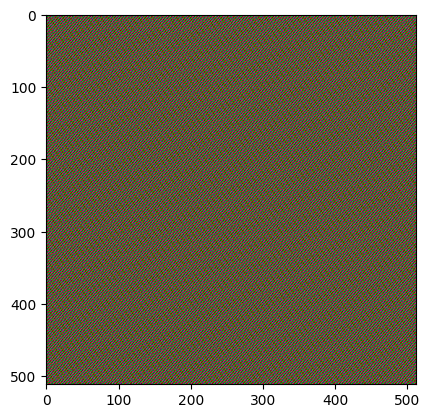

In [191]:
out = si(torch.rand(5, 512))
plt.imshow(out[0].permute(1,2,0).cpu().detach().numpy())
plt.show()

In [170]:
freqs = torch.rand(5, 64, 2)
freqs = freqs @ torch.rand(5, 2, 2)
freqs.shape

torch.Size([5, 64, 2])

In [174]:
freqs.permute(0, 2, 1).unsqueeze(1).unsqueeze(2).shape

torch.Size([5, 1, 1, 2, 64])

In [156]:
theta = torch.eye(2, 3)
theta[0, 0] = 0.5 * 64 / 100
theta

tensor([[0.3200, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000]])

In [159]:
grids = torch.nn.functional.affine_grid(theta.unsqueeze(0), [1, 1, 64, 64], align_corners=False)
grids.shape

torch.Size([1, 64, 64, 2])

In [176]:
x = grids.unsqueeze(3) @ freqs.permute(0, 2, 1).unsqueeze(1).unsqueeze(2)
x.shape

torch.Size([5, 64, 64, 1, 64])

In [133]:
transforms = torch.eye(3,3)
transforms = transforms @ torch.rand(5, 3, 3) @ torch.rand(5, 3, 3)
transforms.shape

torch.Size([5, 3, 3])

In [150]:
transforms[:, :2, 2:].squeeze(2).shape

torch.Size([5, 2])

In [166]:
freqs = torch.rand(5, 64, 2)
freqs = (freqs @ transforms[:, :2, 2:]).squeeze(2)
freqs.shape

torch.Size([5, 64])

In [125]:
t = torch.rand(5, 4)
t = (t / t[:, :2].norm(dim = 1, keepdim = True))
t.shape

torch.Size([5, 4])

In [112]:
m_r = torch.rand([1,3,3]).repeat([5,1,1])
m_r.shape

torch.Size([5, 3, 3])

In [126]:
m_r

tensor([[[0.3285, 0.7153, 0.6975],
         [0.7120, 0.5361, 0.1305],
         [0.0683, 0.9673, 0.1724]],

        [[0.3285, 0.7153, 0.6975],
         [0.7120, 0.5361, 0.1305],
         [0.0683, 0.9673, 0.1724]],

        [[0.3285, 0.7153, 0.6975],
         [0.7120, 0.5361, 0.1305],
         [0.0683, 0.9673, 0.1724]],

        [[0.3285, 0.7153, 0.6975],
         [0.7120, 0.5361, 0.1305],
         [0.0683, 0.9673, 0.1724]],

        [[0.3285, 0.7153, 0.6975],
         [0.7120, 0.5361, 0.1305],
         [0.0683, 0.9673, 0.1724]]])

In [127]:
t[:, 0]

tensor([0.9718, 0.3851, 0.3789, 0.7453, 0.9738])

In [128]:
m_r[:, 0, 1] = t[:, 0]
m_r

tensor([[[0.3285, 0.9718, 0.6975],
         [0.7120, 0.5361, 0.1305],
         [0.0683, 0.9673, 0.1724]],

        [[0.3285, 0.3851, 0.6975],
         [0.7120, 0.5361, 0.1305],
         [0.0683, 0.9673, 0.1724]],

        [[0.3285, 0.3789, 0.6975],
         [0.7120, 0.5361, 0.1305],
         [0.0683, 0.9673, 0.1724]],

        [[0.3285, 0.7453, 0.6975],
         [0.7120, 0.5361, 0.1305],
         [0.0683, 0.9673, 0.1724]],

        [[0.3285, 0.9738, 0.6975],
         [0.7120, 0.5361, 0.1305],
         [0.0683, 0.9673, 0.1724]]])

In [71]:
a.norm(dim = 1, keepdim = True)

tensor([[0.8009],
        [0.4877]])

In [53]:
torch.eye(5,3)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [ ]:
freqs = torch.rand([3, 2]) # Gausian Cloud in 2D space
freqs

tensor([[0.4917, 0.4293],
        [0.2333, 0.6255],
        [0.3529, 0.9713]])

In [31]:
radii = freqs.square().sum(dim = 1, keepdim=True).sqrt()
radii

tensor([[0.6527],
        [0.6676],
        [1.0335]])

In [54]:
freqs / (radii * radii.square().exp().pow(0.25))

tensor([[0.6772, 0.5912],
        [0.3126, 0.8382],
        [0.2615, 0.7196]])